In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pyccl as ccl

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
import warnings

# mute future warnings from theano
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
rels_H = [5.34, 3.51, 2.69, 2.20, 1.85, 1.60, 1.41, 
         1.35, 1.42, 1.41, 1.38, 1.36, 1.46, 1.66, 
         2.04, 3.15, 4.87, 6.55]

In [5]:
params = {'h': 0.6732,
        'Omega_cdm': 0.265, #0.27
        'Omega_b': 0.050,
        'n_s': 0.9665 }#

#cosmo_ccl = ccl.Cosmology(param_dict)
classy = ccl.boltzmann.classy.Class()
classy.set(params)
classy.compute()

In [6]:
dz = 0.1
z_arr = np.arange(0.15, 1.85+0.1, dz)

In [7]:
len(z_arr)

18

In [8]:
E100_arr = np.array([])
H_arr = np.array([])
H0 = classy.Hubble(0)
for z in z_arr: 
            #We can worry about the rs_drag later
            H = classy.Hubble(z)
            E100 = 100*H/H0
            E100_arr = np.append(E100_arr, E100)
            H_arr = np.append(H_arr, H)

In [9]:
sig_E100_arr = E100_arr*rels_H/100
sig_H_arr = H_arr*rels_H/100

In [10]:
n = len(z_arr)  # The number of data points
X = z_arr[:, None]  # The inputs to the GP must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 0.2
η_true = 6.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
mod = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

In [11]:
# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
y = (mod+E100_arr) + sig_E100_arr * np.random.randn(n)

Text(0, 0.5, 'y')

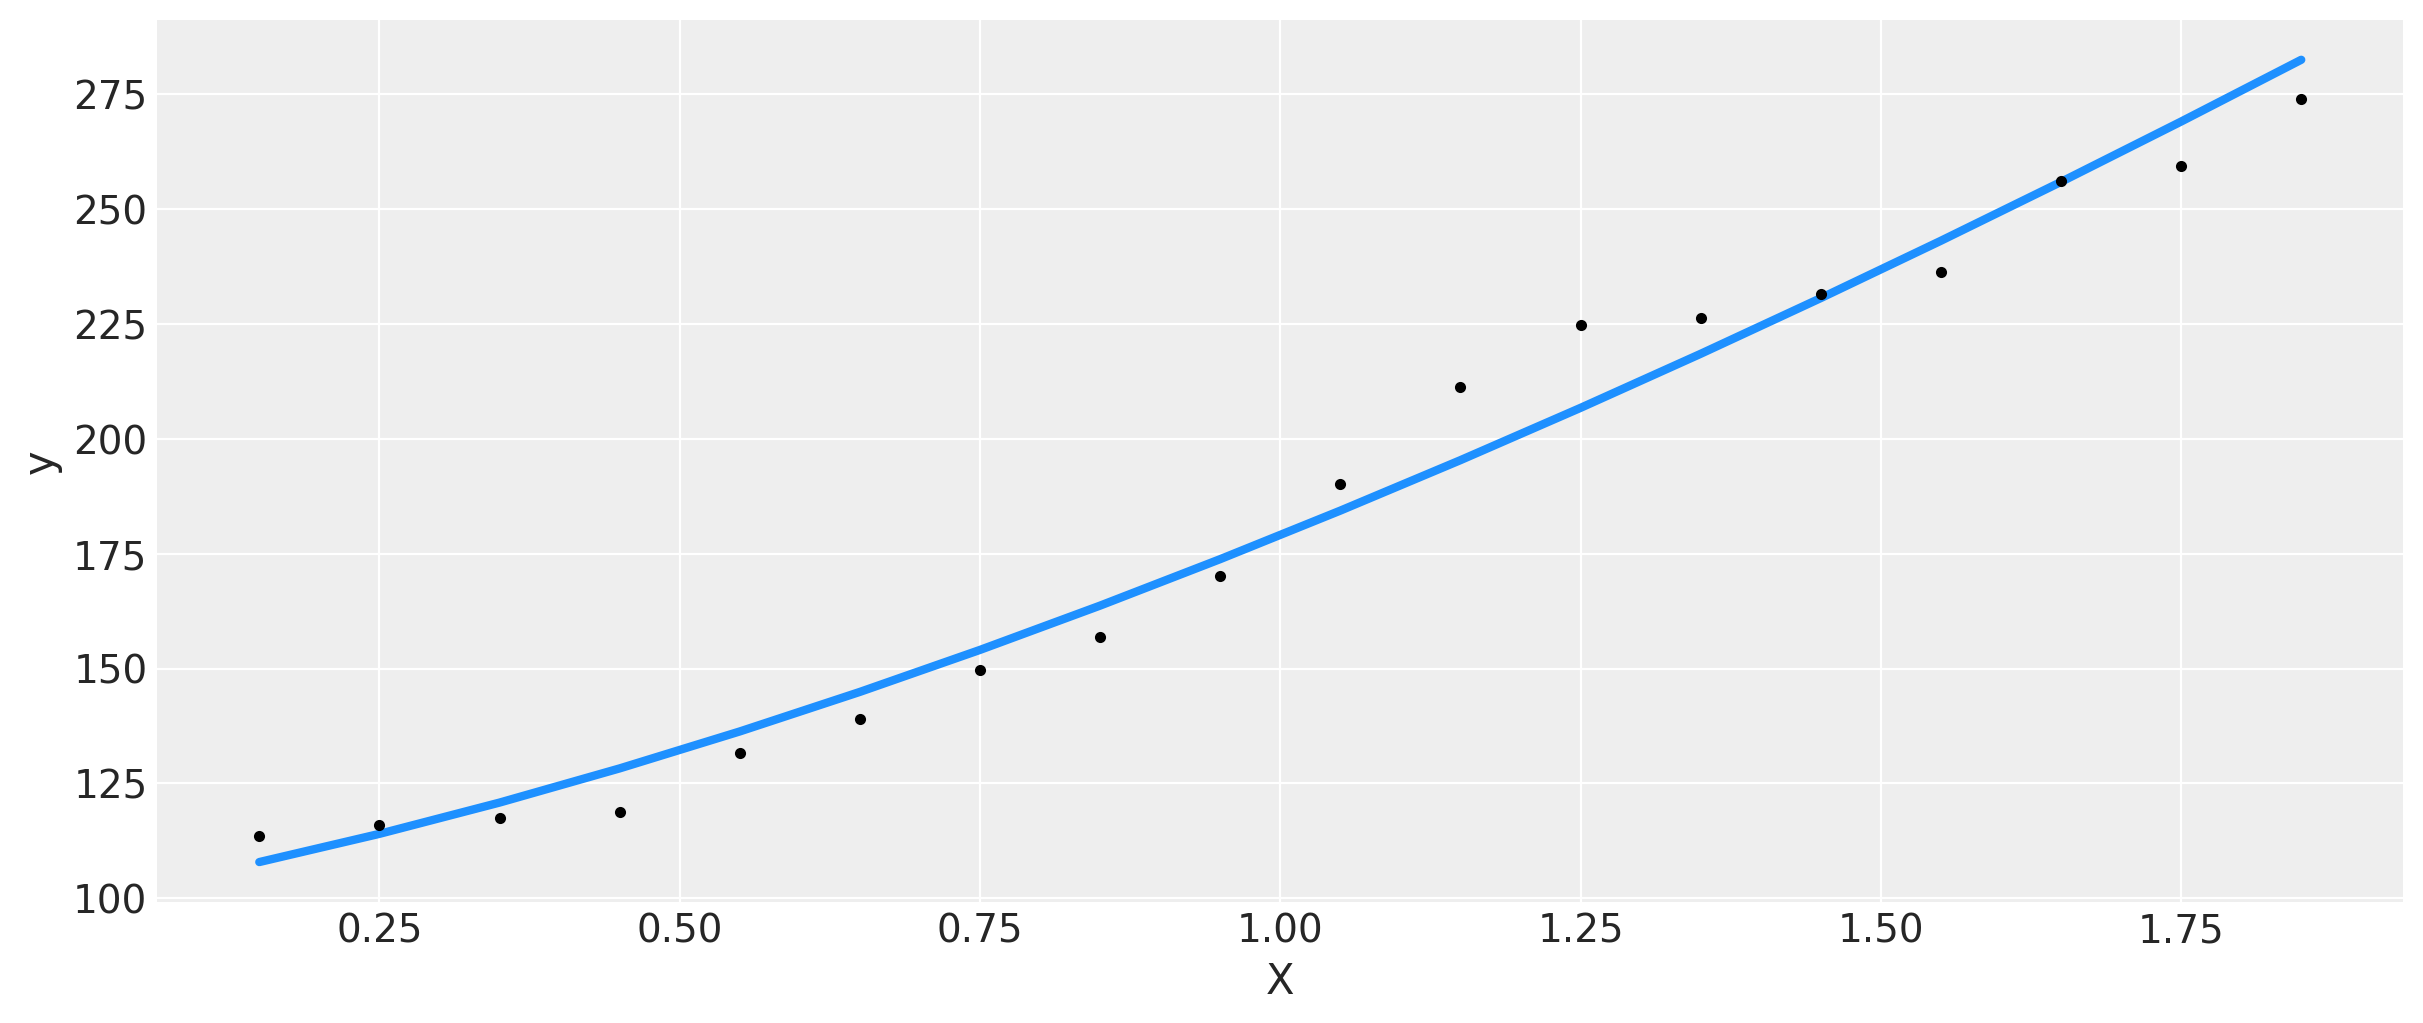

In [12]:
## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, E100_arr, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")
ax.set_xlabel("X")
ax.set_ylabel("y")

In [13]:
E100_cov = np.zeros([len(z_arr), len(z_arr)])
H_cov = np.zeros([len(z_arr), len(z_arr)])
#dA_cov = np.zeros([len(z_arr), len(z_arr)])
for i in np.arange(len(z_arr)):
    E100_cov[i,i] = sig_E100_arr[i]**2
    H_cov[i,i] = sig_H_arr[i]**2
    #dA_cov[i,i] = sig_dA_arr[i]**2

In [14]:
#Unconstraint
with pm.Model() as model:
    ℓ = pm.Uniform("ℓ", 0, 1) 
    η = pm.Uniform("η", 0, 8) 

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    Df = gp.prior("Df", X=X)
    f = pm.Deterministic("f", Df+E100_arr)

    σ = pm.HalfCauchy("σ", beta=5)
    #ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.MvNormal("y", mu=f, cov=E100_cov, observed=y)

    trace = pm.sample(100, chains=1, cores=1, tune = 200, return_inferencedata=True)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [σ, Df_rotated_, η, ℓ]


Sampling 1 chain for 200 tune and 100 draw iterations (200 + 100 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


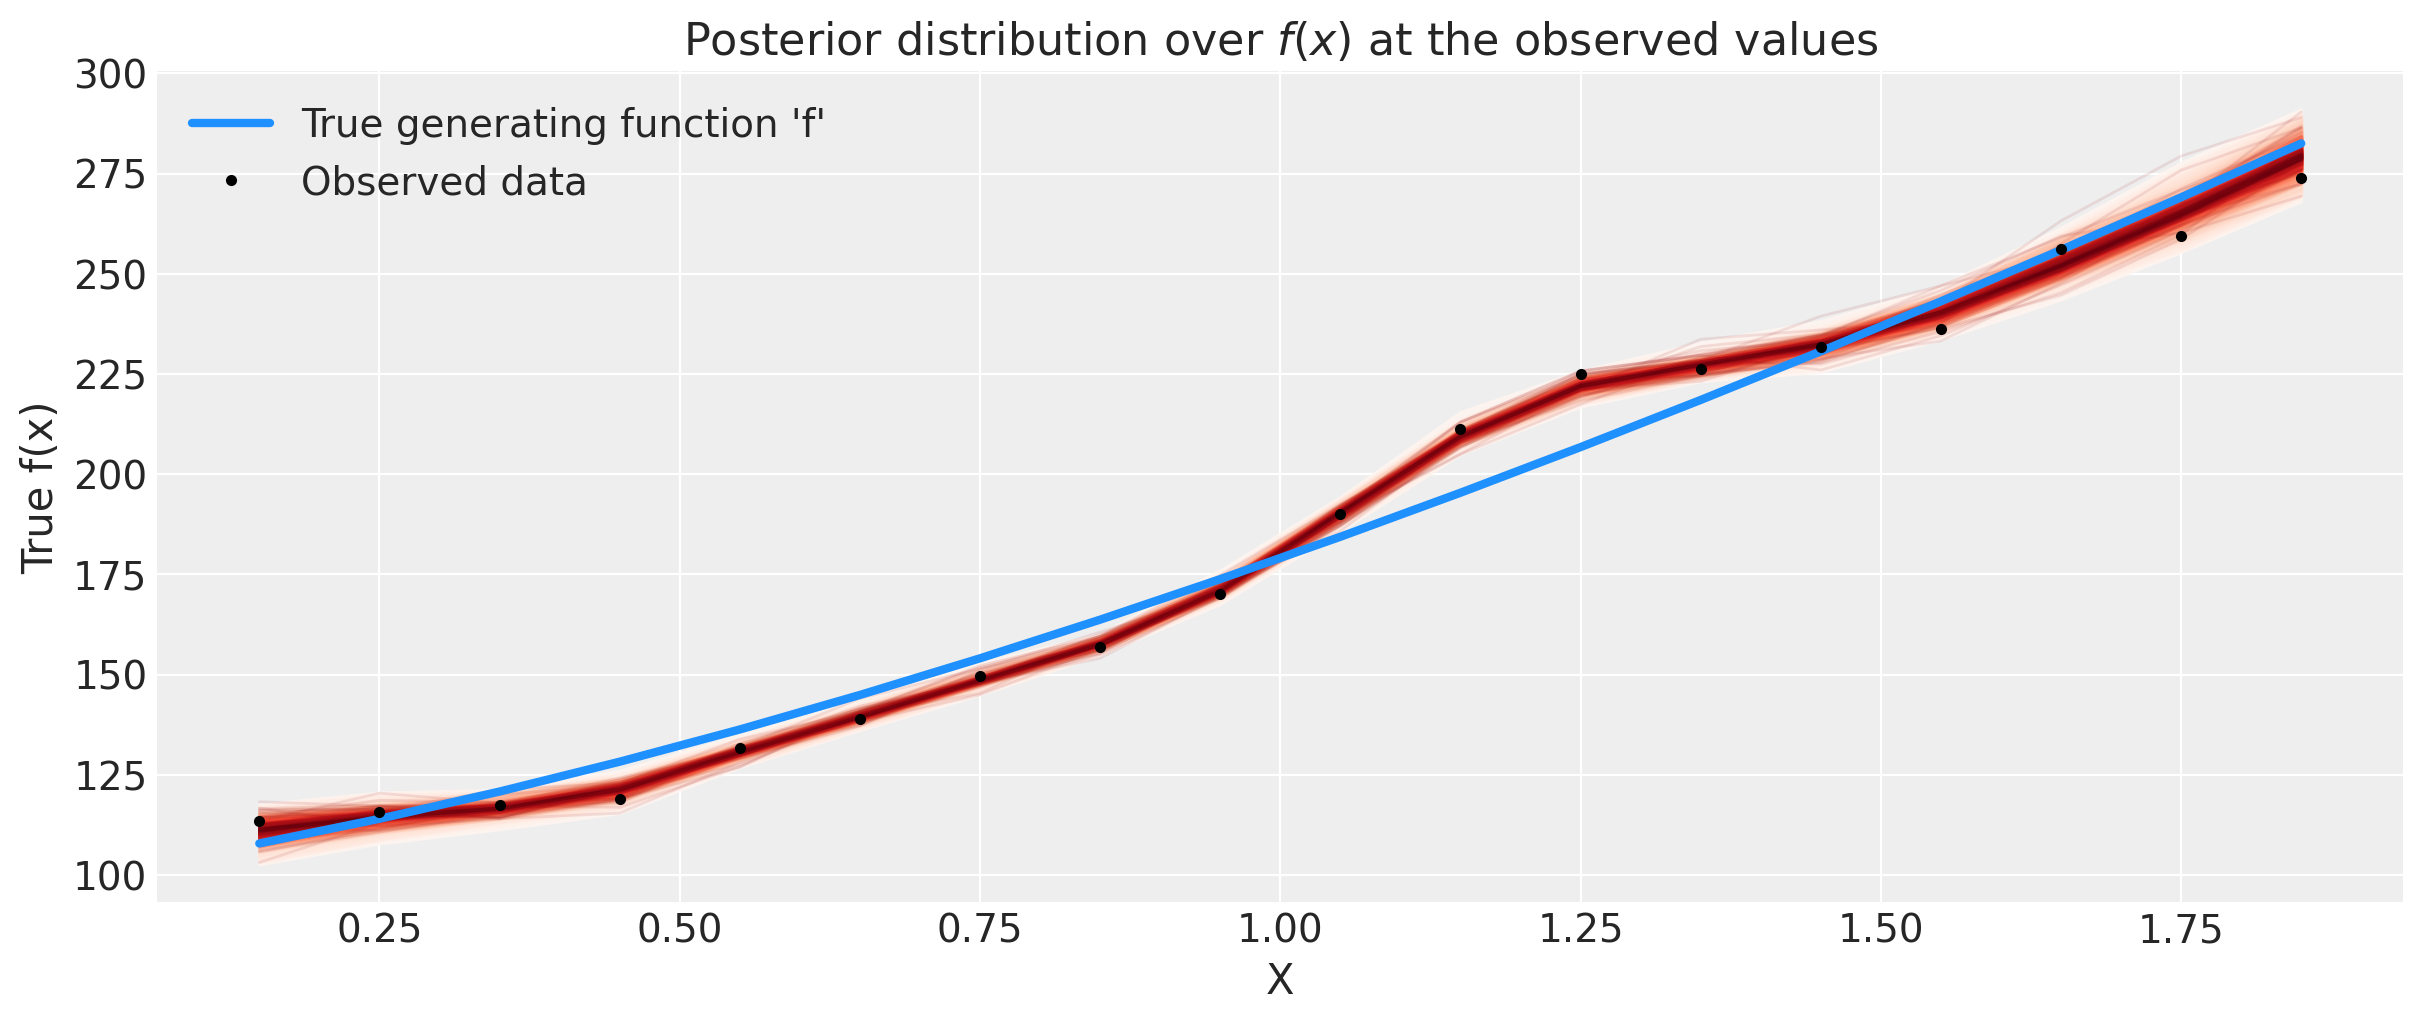

In [15]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["f"][0, :, :], X)

# plot the data and the true latent function
ax.plot(X, E100_arr, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

<ipython-input-16-e1138b7d907f>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  fig = pm.traceplot(trace)


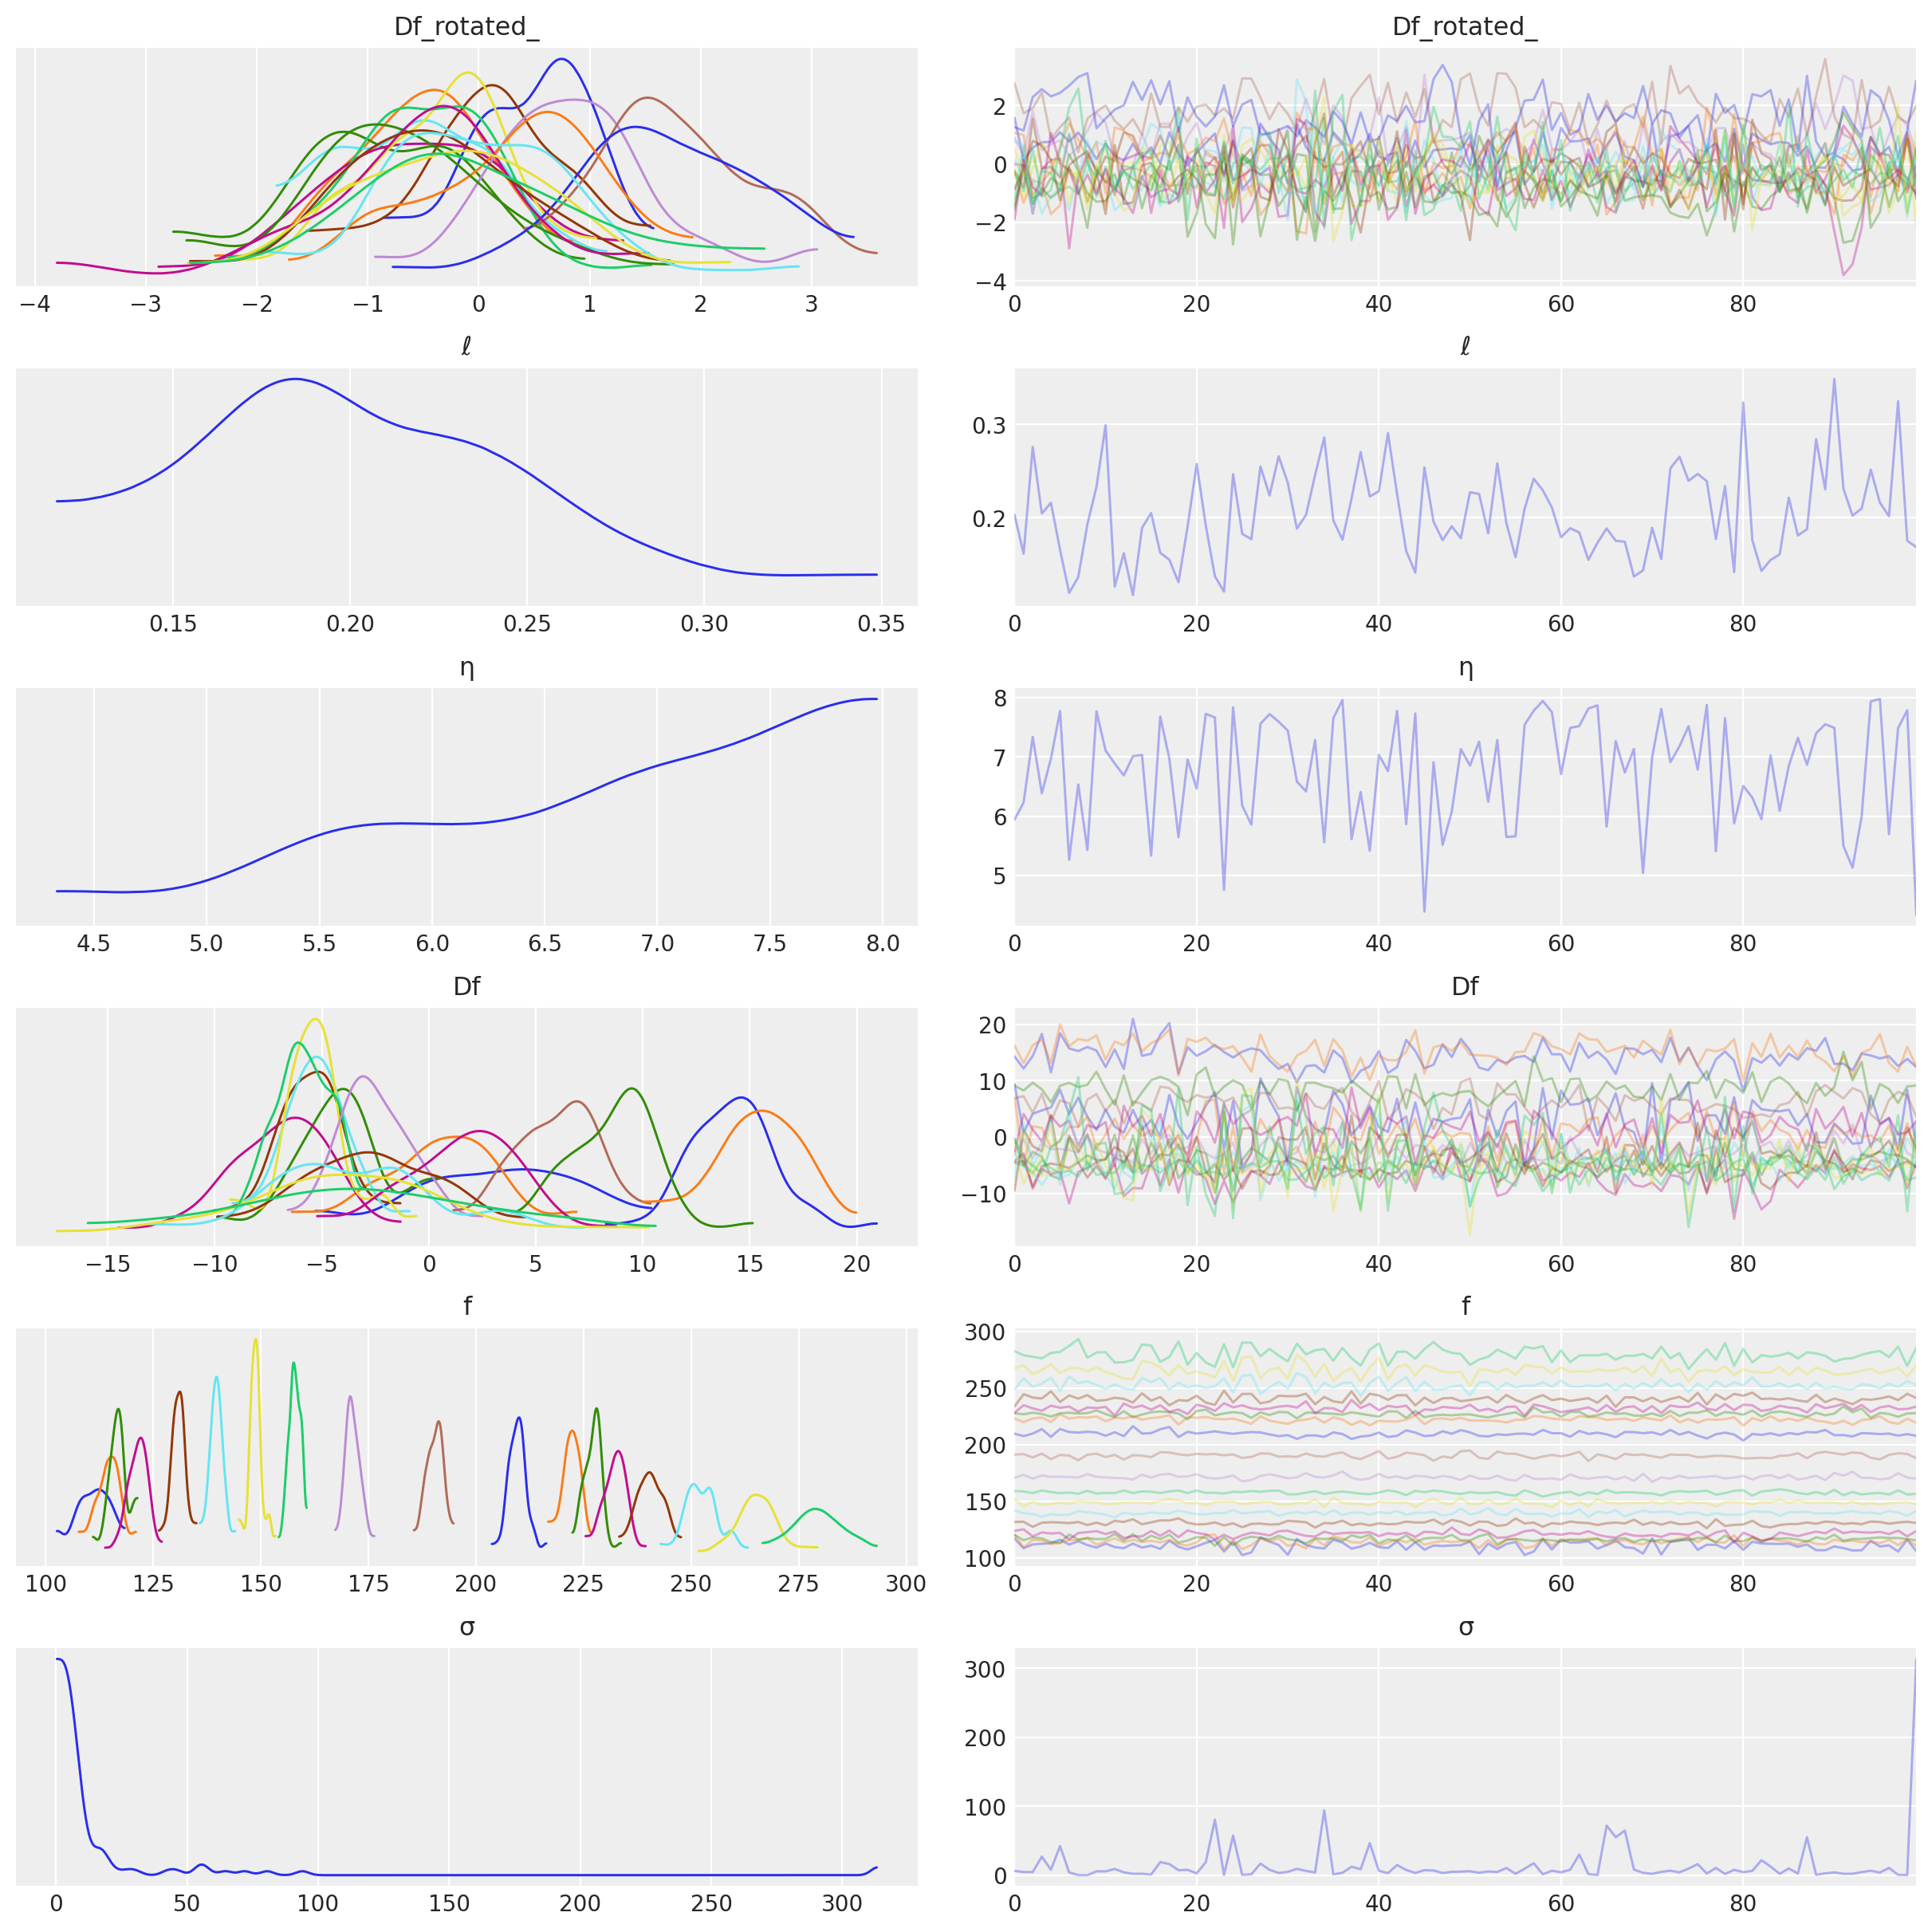

In [16]:
fig = pm.traceplot(trace)

In [17]:
# 200 new values from x=0 to x=15
z_new = np.arange(0., 2.85+0.1, dz)
X_new = z_new[:, None]

In [18]:
E100_new = np.array([])
H_new = np.array([])
for z in z_new: 
            #We can worry about the rs_drag later
            H = classy.Hubble(z)
            E100 = 100*H/H0
            E100_new = np.append(E100_new, E100)
            H_new = np.append(H_new, H)

In [19]:
# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, var_names=['f_pred'])

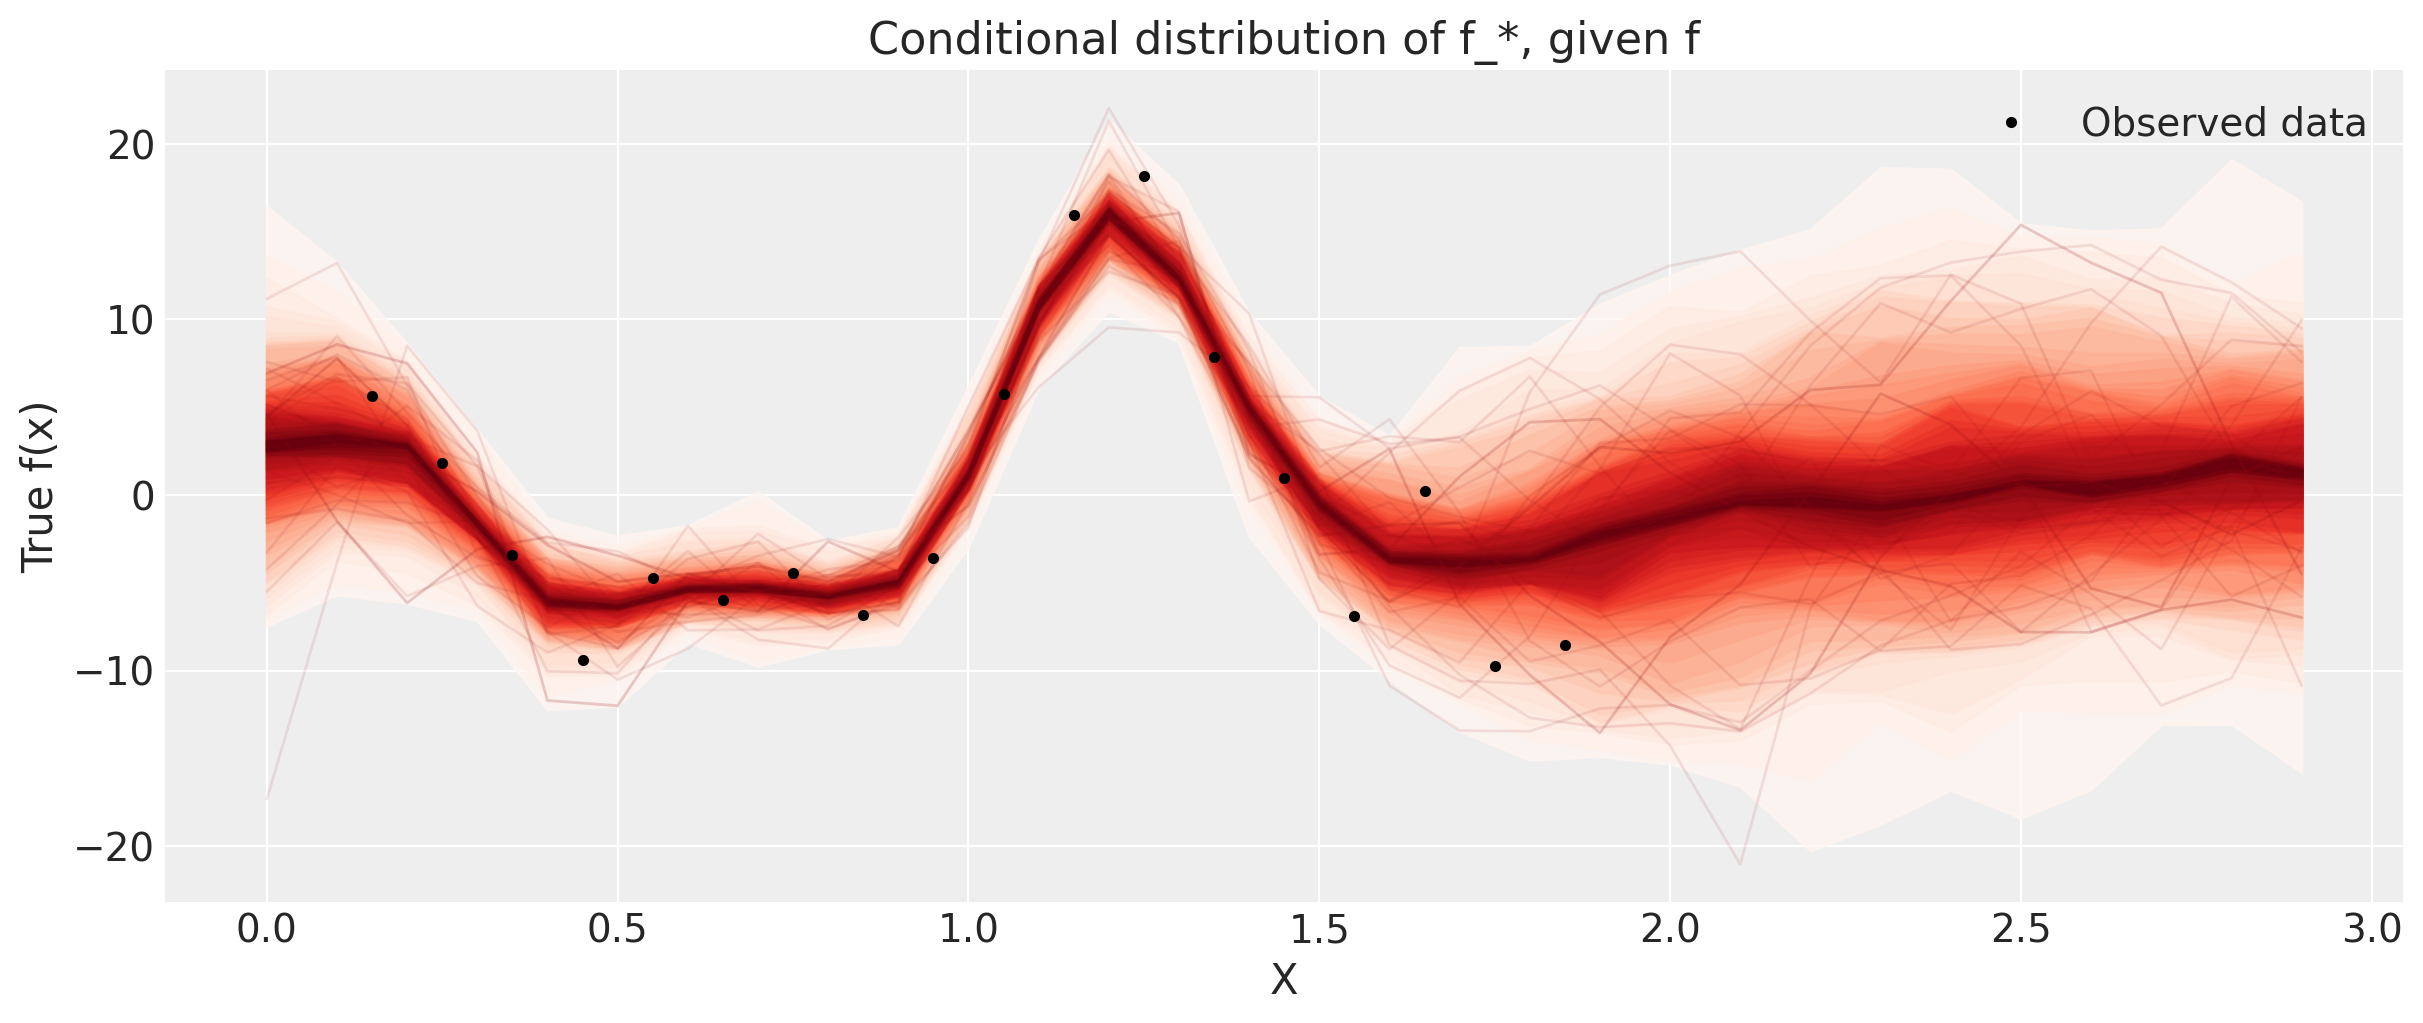

In [20]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new)

#ax.plot(X, E100_arr, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y-E100_arr, "ok", ms=3, label="Observed data")

ax.set_xlabel("X")
ax.set_ylabel("True f(x)")
ax.set_title("Conditional distribution of f_*, given f")
plt.legend();